In [1]:
# GOOGLE COLLAB
! rm -rf output/
! rm -rf __MACOSX/ landscapes data
! mkdir data
! curl https://cv-project-parceros.s3.amazonaws.com/chess_images.zip --output images.zip
! unzip images.zip
! rm -rf __MACOSX/
! mv chess_images data/chess_images


Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: chess_images/peon_rojo/peon_rojo_26_596.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_27_785.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_27_949.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_26_582.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_27_791.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_27_961.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_27_975.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_26_347.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_27_154.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_27_632.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_26_421.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_27_626.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_26_435.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_26_353.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_27_140.jpg  
  inflating: chess_images/peon_rojo/peon_rojo_27

In [2]:
! ls data/chess_images

alfil_azul    caballo_rojo  peon_azul	reina_rojo  torre_azul
alfil_rojo    fondo_blanco  peon_rojo	rey_azul    torre_rojo
caballo_azul  fondo_negro   reina_azul	rey_rojo


In [3]:
!pip install split-folders
import splitfolders
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("data/chess_images", output="output", seed=1337, ratio=(.7, .1, .2), group_prefix=None) # default values

Copying files: 32032 files [00:04, 7890.35 files/s]


In [20]:
! ls ./output

test  train  val


In [21]:
import torch

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from time import time
from skimage import io, color
from torchvision import datasets
from skimage.color import lab2rgb, rgb2lab, rgb2gray

%matplotlib inline

In [22]:
transform = transforms.Compose([
    #transforms.Grayscale(),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

transform_train = transforms.Compose([
    #transforms.Grayscale(),
    transforms.Resize((80,80)),
    transforms.RandomCrop((64, 64)),
    transforms.RandomRotation((-35, 35)),
    transforms.ToTensor(),
])

dataset_train = datasets.ImageFolder("./output/train", transform=transform_train)
dataset_val = datasets.ImageFolder("./output/val", transform=transform)
dataset_test = datasets.ImageFolder("./output/test", transform=transform)

data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, num_workers=0, shuffle=True)
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=32, num_workers=0, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, num_workers=0, shuffle=True)

dataiter_train = iter(data_loader_train)
dataiter_val = iter(data_loader_val)
dataiter_test = iter(data_loader_val)

In [23]:
print(dataset_train.class_to_idx)

{'alfil_azul': 0, 'alfil_rojo': 1, 'caballo_azul': 2, 'caballo_rojo': 3, 'fondo_blanco': 4, 'fondo_negro': 5, 'peon_azul': 6, 'peon_rojo': 7, 'reina_azul': 8, 'reina_rojo': 9, 'rey_azul': 10, 'rey_rojo': 11, 'torre_azul': 12, 'torre_rojo': 13}


In [24]:
print(len(data_loader_test))
print(len(data_loader_val))

201
100


In [25]:
images, labels = dataiter_train.next()
print(images.shape )

torch.Size([32, 3, 64, 64])


In [26]:
print(labels)

tensor([ 8, 13,  1, 11,  4,  6, 10,  2,  2,  1,  0,  8,  5,  9,  7, 11,  9,  0,
         5,  5,  4,  2,  4,  2,  4,  7,  4, 13,  6,  6,  2,  5])


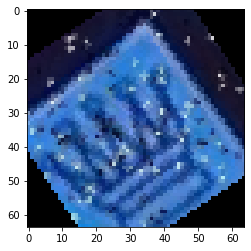

In [27]:
images, labels = dataiter_train.next()
plt.imshow(np.transpose(images[13], (1,2,0)))

In [30]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        self.pool2 = nn.MaxPool2d(2,2)
        self.pool4 = nn.MaxPool2d(4,4)
        # First conv layers
        self.conv1 = nn.Conv2d(3, 64, 7, padding=3)
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256,512, 7, padding=3)
        #self.conv5 = nn.Conv2d(12,6, 3, padding=1)
        #self.conv6 = nn.Conv2d(6,3, 1, padding=0)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 14)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool2(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool4(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        #x = F.relu(self.conv5(x))
        #x = F.relu(self.conv6(x))
        x = x.view(x.shape[0], -1)
        # add dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# initialize the NN
model = ConvAutoencoder()

# Testing purposes 
X = torch.rand((1,3,64,64))
Y = model(X)
print(X.shape, Y.shape)

torch.Size([1, 3, 64, 64]) torch.Size([1, 14])


In [31]:
print(f'Using {["CPU", "CUDA"][torch.cuda.is_available()]}')
model = model.cuda() if torch.cuda.is_available() else model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Using CUDA


In [32]:
cuda_available = torch.cuda.is_available()

In [33]:
valid_loss_min = np.Inf

In [35]:
# number of epochs to train the model
n_epochs = 20

model.train()
for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    # monitor training loss
    train_loss = 0.0
    model.train()
    
    ###################
    # train the model #
    ###################
    
    for data in data_loader_train:
        #start = time()
        # Get both images, images_gray is the input, images is the expected output
        images, labels = data

        if cuda_available:
            images = images.cuda()
            labels = labels.cuda()

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
       
        # calculate the loss
        loss = criterion(outputs, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in data_loader_val:
        # move tensors to GPU if CUDA is available
        if cuda_available:
            images = data.cuda()
            target = target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(data_loader_train.sampler)
    valid_loss = valid_loss/len(data_loader_val.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
      
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss)
        )
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
      
      #print(time() - start)
      #break

Epoch: 1 	Training Loss: 0.011683 	Validation Loss: 0.668317
Epoch: 2 	Training Loss: 0.007087 	Validation Loss: 0.552604
Epoch: 3 	Training Loss: 0.005801 	Validation Loss: 0.895932
Epoch: 4 	Training Loss: 0.009037 	Validation Loss: 0.569301
Epoch: 5 	Training Loss: 0.005401 	Validation Loss: 0.325691
Validation loss decreased (0.326664 --> 0.325691).  Saving model ...
Epoch: 6 	Training Loss: 0.004693 	Validation Loss: 0.799233
Epoch: 7 	Training Loss: 0.006501 	Validation Loss: 0.661609
Epoch: 8 	Training Loss: 0.004255 	Validation Loss: 0.729203
Epoch: 9 	Training Loss: 0.003128 	Validation Loss: 0.645033
Epoch: 10 	Training Loss: 0.009509 	Validation Loss: 0.214179
Validation loss decreased (0.325691 --> 0.214179).  Saving model ...
Epoch: 11 	Training Loss: 0.005461 	Validation Loss: 0.353896
Epoch: 12 	Training Loss: 0.005983 	Validation Loss: 0.299487
Epoch: 13 	Training Loss: 0.004231 	Validation Loss: 0.451115
Epoch: 14 	Training Loss: 0.003264 	Validation Loss: 0.401629
Epo

In [36]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [37]:
model.eval()
incorrect = []
correct, total = 0, 0

for data in data_loader_test:
    images, labels = data
    if cuda_available:
      images = images.cuda()
      labels = labels.cuda()

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i, b in enumerate(c.cpu().numpy()):
      if not b: incorrect.append(images[i])
    correct += sum(c).item()
    total += len(c)
  
print(f'ACC: {correct / total}')

ACC: 0.9359413965087282


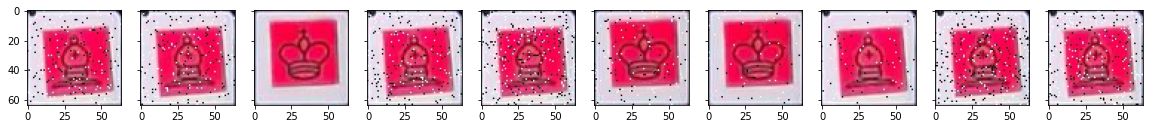

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(20,10))
for i in range(10):
    axes[i].imshow(np.transpose(incorrect[i].cpu(), (1, 2, 0)))

In [39]:
  print(correct, total)

6005 6416


In [40]:
torch.save(model.state_dict(), 'model.pt')

In [41]:
import torch
import chess
import chess.svg
import chess.engine

import cv2 as cv
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image

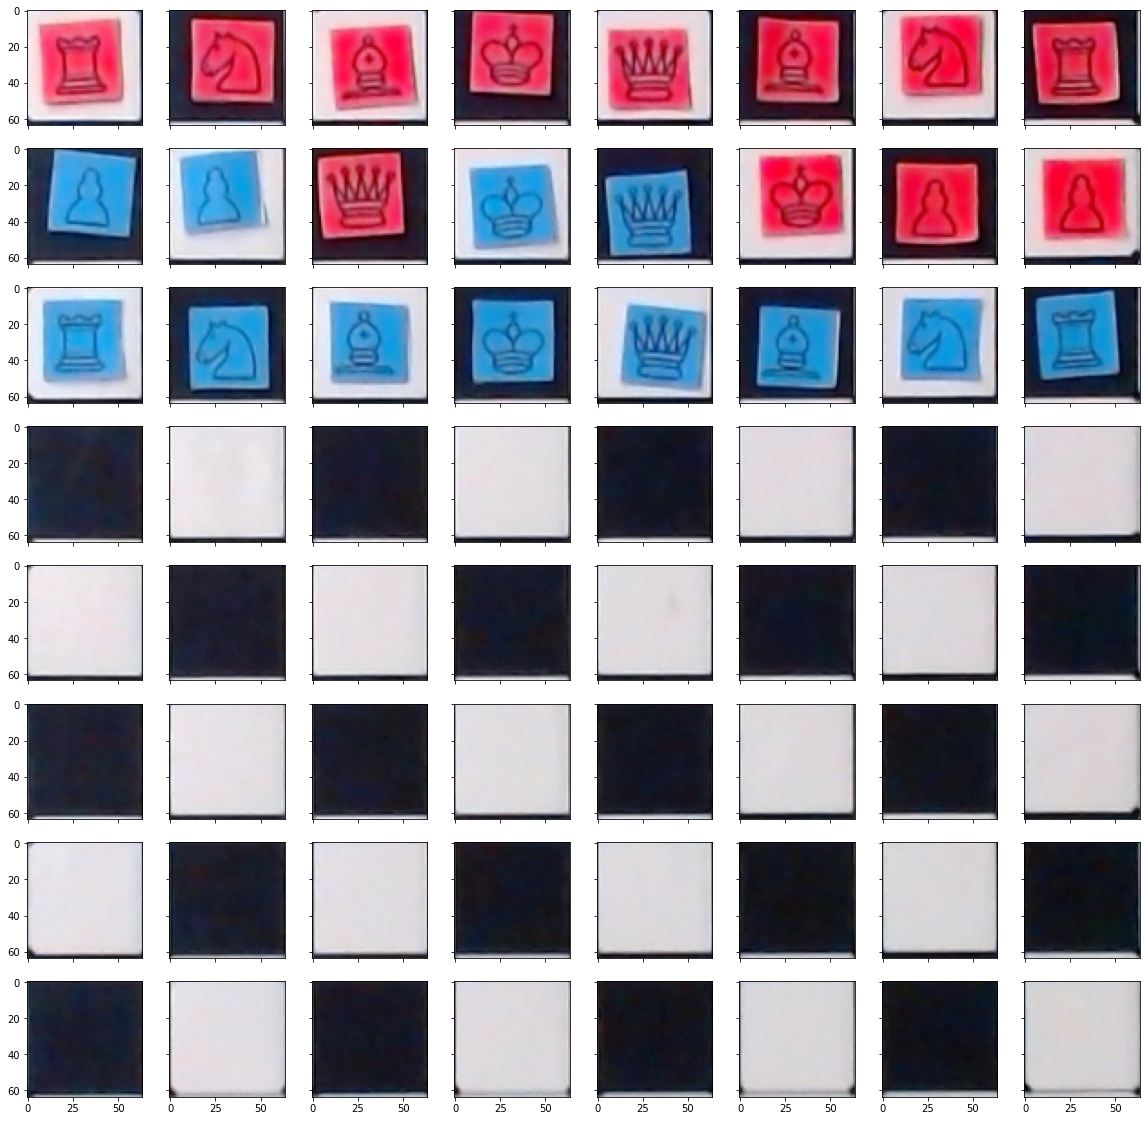

In [43]:
img = cv.imread('original.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

rows,cols,ch = img.shape
pts1 = np.float32([[58, 116], [698, 102], [28, 718], [739, 718]])
pts2 = np.float32([[0,0],[512,0],[0,512],[512,512]])
M = cv.getPerspectiveTransform(pts1, pts2)
dst = cv.warpPerspective(img,M,(512, 512))

fig, axes = plt.subplots(nrows=8, ncols=8, sharex=True, sharey=True, figsize=(20,20))

squares = []
for i in range(8):
    for j in range(8):
        img2 = dst[64*i:64*i + 64, 64*j:64*j + 64]
        squares.append(img2)
        axes[i][j].imshow(img2)

In [44]:
squares = np.array(squares)
squares = squares.transpose((0, 3, 1, 2))
x = torch.from_numpy(squares).float()

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        self.pool2 = nn.MaxPool2d(2,2)
        self.pool4 = nn.MaxPool2d(4,4)
        # First conv layers
        self.conv1 = nn.Conv2d(3, 64, 7, padding=3)
        self.conv2 = nn.Conv2d(64, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256,512, 7, padding=3)
        #self.conv5 = nn.Conv2d(12,6, 3, padding=1)
        #self.conv6 = nn.Conv2d(6,3, 1, padding=0)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 14)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool2(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool4(x)
        x = F.relu(self.conv4(x))
        
        x = self.pool4(x)
        #x = F.relu(self.conv5(x))
        #x = F.relu(self.conv6(x))
        x = x.view(x.shape[0], -1)
        # add dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [45]:
# initialize the NN
model = ConvAutoencoder()
model.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))

mapping = {
    'alfil_azul': 0,
    'alfil_rojo': 1,
    'caballo_azul': 2,
    'caballo_rojo': 3,
    'fondo_blanco': 4,
    'fondo_negro': 5,
    'peon_azul': 6,
    'peon_rojo': 7,
    'reina_azul': 8,
    'reina_rojo': 9,
    'rey_azul': 10,
    'rey_rojo': 11,
    'torre_azul': 12,'torre_rojo': 13}
rev_mapping = {v:k for k,v in mapping.items()}


def idx2piece(idx):
    return get_piece(rev_mapping[idx.item()])


def get_piece(piece):
        return {
            'alfil_azul': 'b',
            'alfil_rojo': 'B',
            'caballo_azul': 'n',
            'caballo_rojo': 'N',
            'peon_azul': 'p',
            'peon_rojo': 'P',
            'reina_azul': 'q',
            'reina_rojo': 'Q',
            'rey_azul': 'K',
            'rey_rojo': 'k',
            'torre_azul': 'r',
            'torre_rojo': 'R'
        }.get(piece, '.')

    
get_piece_ = lambda piece: {".": False}.get(piece, piece)
    
def from_board_to_fne(board):
    fne_board = []
    # 'for loop' until the shape is defined
    for row in board.splitlines():
        fne_row = ""
        empty_spaces = 0
        for piece in row:
            piece = get_piece_(piece)
            if piece:
                if empty_spaces:
                    fne_row += str(empty_spaces)
                    fne_row += piece
                else:
                    fne_row += piece

                empty_spaces = 0
            else:
                empty_spaces += 1

        if empty_spaces:
            fne_row += str(empty_spaces)

        fne_board.append(fne_row)

    return "/".join(fne_board)[1:]

from itertools import groupby
def board2fne(board):
    for row in board:
        for k, g in groupby(row):
            print(k,g)

board = """
..b.....
pppp.Qpp
..n..n..
....p...
..B.P...
........
PPPP.PPP
RNB.K.NR
"""

print(from_board_to_fne(board))


2b5/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR


In [46]:
y = model(x)
y = model(x)
y = torch.max(y, 1)

print(y)


torch.return_types.max(
values=tensor([ 4541.1357,  4495.0483,  4198.1016,  3886.2224,  4333.9258,  2963.9031,
         6868.4219,  3765.0598,  9941.5820, 11822.6406,  3563.2759,  4444.0366,
         6054.9941,  5021.7061,  5434.6050,  5975.7935,  6355.6001,  6171.0215,
         5021.4736,  6726.3677,  4754.5181,  5967.2622,  5596.8604,  6957.9189,
         1357.2223,  7172.1841,   842.5184,  6024.8955,   951.3852,  6855.7715,
         1006.5610,  6003.2305,  7345.0845,  1138.0481,  6952.3076,  1045.9723,
         5664.2007,  1116.8474,  6084.4688,   913.0561,  1198.8821,  7300.3286,
          993.3130,  5141.9136,  1001.1856,  5069.3525,  1534.5822,  5645.1738,
         7108.0107,  1012.1431,  5860.1172,  1063.6777,  5464.2295,  1299.1166,
         4451.2510,  2192.1370,  1130.3951,  7524.3843,   865.6426,  5810.7900,
         1121.7347,  6330.2515,  1698.6537,  5857.6606],
       grad_fn=<MaxBackward0>),
indices=tensor([13,  3, 13, 11, 13,  7,  3,  7,  6,  6,  9,  6,  6,  7,  7,  3, 

In [75]:
board = [[None for j in range(8)] for j in range(8)]
for i, piece in enumerate(map(idx2piece,y.indices)):
    board[i // 8][i % 8] = piece

board = '\n'.join(str(''.join(row)) for row in board)
board_str = '\n' + board
board_fen = from_board_to_fne(board_str)

In [76]:

#board_fen = "4r1k1/1p2P2p/1nr5/1B1p2p1/p4pP1/1P3P2/P6P/3RR1K1"
board_fen
y.indices


tensor([13,  3, 13, 11, 13,  7,  3,  7,  6,  6,  9,  6,  6,  7,  7,  3,  6,  6,
         6,  6,  6,  6,  6,  6,  8,  4,  8,  4,  8,  4,  8,  4,  4,  4,  4,  4,
         4,  8,  4,  2,  4,  4,  4,  8,  8,  4,  8,  4,  4,  8,  8,  8,  4,  8,
         8,  2,  8,  4,  4,  4,  8,  8,  8,  4])

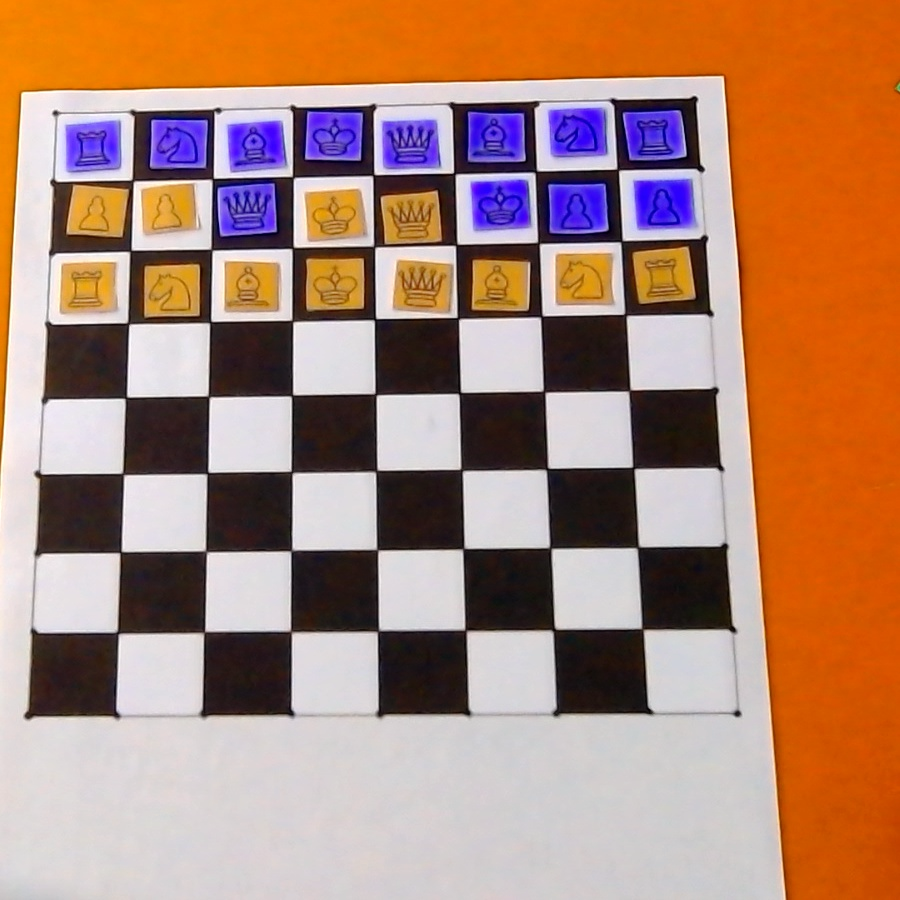

In [81]:
display(Image.fromarray(cv.imread("original.jpg")))

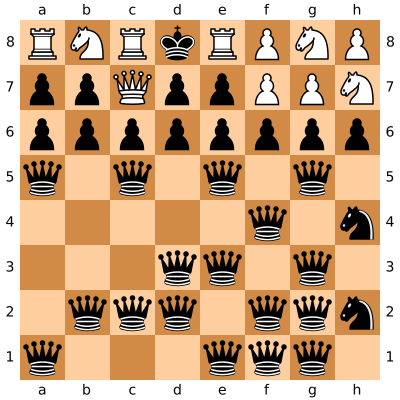

In [78]:
board_white = chess.Board(f'{board_fen} w KQkq - 0 1')
#board_black = chess.Board(f'{board_fen} b')

board_white

In [ ]:
-